# Yaw Robustness Analysis

This notebook generates:
1. Success Rate vs Yaw Noise bar plot
2. Break Rate vs Yaw Noise bar plot

In [6]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

# Import and reload shared utilities (reload picks up changes without rerunning blocks 2-3)
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    TAG_EVAL_PERFORMANCE, TAG_EVAL_YAW,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_data,
    # Plotting functions
    plot_rate_figure,
    print_data_summary,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Method Tags
METHOD_TAGS = {
    #"Pose(3deg)": "pose_hex_state-std:2026-01-26_18:36",
    #"MATCH(3deg)": "MATCH_hex_state-std:2026-01-26_17:33",
    #"Pose": "pose_hex-15deg:2026-02-04_17:45",
    #"MATCH": "MATCH_hex-15deg:2026-02-04_17:45",
    #"Hybrid-Basic":"basic-hybrid_hex-15deg:2026-02-04_17:45",

    # squashed v1
    #"Pose": "pose_squashed_hex-15deg_f10000:2026-02-24_16:39",
    #"Hybrid-Basic":"hybrid_squashed_hex-15deg_f10000:2026-02-24_16:39",
    #"Hybrid-MATCH":"MATCH_squashed_hex-15deg_f10000:2026-02-24_16:39",

    # squashed v2
    "Pose" : "pose_squashed_hex-15deg_f10000:2026-02-25_18:37",
    "Hybrid-Basic":"hybrid_squashed_hex-15deg_f10000:2026-02-25_18:37",
    "Hybrid-MATCH":"MATCH_squashed_hex-15deg_f10000:2026-02-25_18:37",
}

# Yaw Level Mapping: display label -> metric range string
# NOTE: The 0deg range has a leading space in wandb: " 0deg-15deg"
YAW_LEVELS = {
    "15°": "0deg-15deg",
    "30°": "15deg-30deg",
    "45°": "30deg-45deg",
    "60°": "45deg-60deg",
}

# Policy Selection
TOP_N_POLICIES = None
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Plot Configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 15)
BREAK_Y_TICKS = list(range(15))

# Error type: "ci" for 95% confidence interval, "binary_se" for binary standard error
ERROR_TYPE = "ci"

In [7]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(
        api, method_tag, max_checkpoint=MAX_CHECKPOINT
    )


Pose (pose_squashed_hex-15deg_f10000:2026-02-25_18:37):
  Eval_performance_pose_squashed_hex-15deg_f(10000)_0: best checkpoint at step 12633600 (score: 100)
  Eval_performance_pose_squashed_hex-15deg_f(10000)_1: best checkpoint at step 14745600 (score: 99)
  Eval_performance_pose_squashed_hex-15deg_f(10000)_2: best checkpoint at step 11212800 (score: 100)
  Eval_performance_pose_squashed_hex-15deg_f(10000)_3: best checkpoint at step 4262400 (score: 92)
  Eval_performance_pose_squashed_hex-15deg_f(10000)_4: best checkpoint at step 6220800 (score: 100)

Hybrid-Basic (hybrid_squashed_hex-15deg_f10000:2026-02-25_18:37):
  Eval_performance_hybrid_squashed_hex-15deg_f(10000)_0: best checkpoint at step 13632000 (score: 100)
  Eval_performance_hybrid_squashed_hex-15deg_f(10000)_1: best checkpoint at step 12595200 (score: 99)
  Eval_performance_hybrid_squashed_hex-15deg_f(10000)_2: best checkpoint at step 14361600 (score: 96)
  Eval_performance_hybrid_squashed_hex-15deg_f(10000)_3: best checkp

In [8]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

yaw_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading data for {method_name}...")
    yaw_data[method_name] = download_eval_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        level_mapping=YAW_LEVELS,
        prefix_template="Yaw_Eval({level})_Core",
        level_col_name="yaw_level",
        eval_tag=TAG_EVAL_YAW,
    )

# Print summary
print_data_summary(
    data=yaw_data,
    level_labels=list(YAW_LEVELS.keys()),
    level_col="yaw_level",
    metric="success",
    title="YAW DATA SUMMARY (Success Rate)",
)




YAW DATA SUMMARY (Success Rate)

Pose:
  15°: 96.3% (n=5)
  30°: 91.0% (n=5)
  45°: 79.4% (n=5)
  60°: 72.7% (n=5)

Hybrid-Basic:
  15°: 96.2% (n=5)
  30°: 93.3% (n=5)
  45°: 87.8% (n=5)
  60°: 77.8% (n=5)

Hybrid-MATCH:
  15°: 98.8% (n=5)
  30°: 96.4% (n=5)
  45°: 90.5% (n=5)
  60°: 79.4% (n=5)


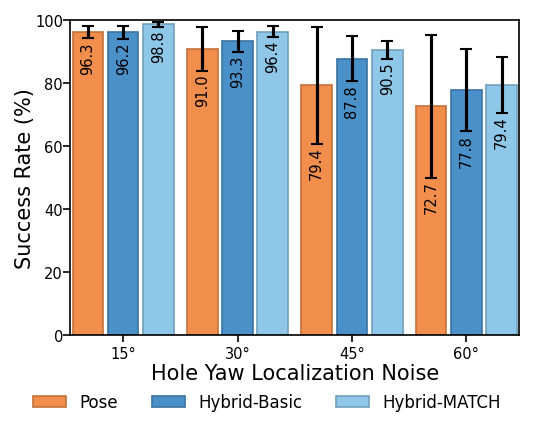

In [15]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS YAW NOISE
# ============================================================

fig, ax = plot_rate_figure(
    data=yaw_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(YAW_LEVELS.keys()),
    level_col="yaw_level",
    metric="success",
    #title="Success Rate vs Hole Yaw Noise",
    x_label="Hole Yaw Localization Noise",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=None,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()

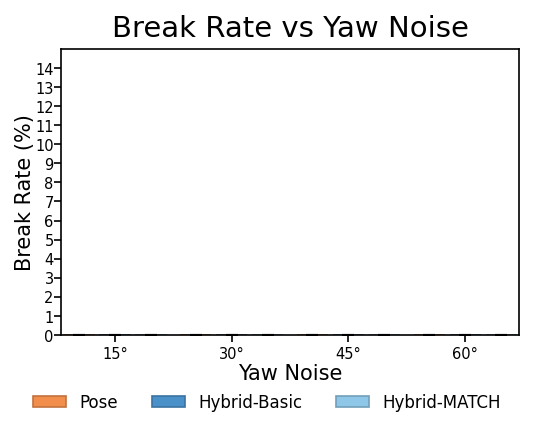

In [11]:
# ============================================================
# BLOCK 5: BREAK RATE VS YAW NOISE
# ============================================================

fig, ax = plot_rate_figure(
    data=yaw_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(YAW_LEVELS.keys()),
    level_col="yaw_level",
    metric="breaks",
    title="Break Rate vs Yaw Noise",
    x_label="Yaw Noise",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()